# Cuestionario 2 Sergio Santiago

Autor: Sergio Santiago<br>
Última actualización: 3 de Diciembre, 2024

Durante el siguiente documentos estudiaremos la naturaleza de los datos recogidos sobre el cáncer de mama por la universidad de Wisconsin. Dichos datos pueden enocntrase en el siguiente enlace https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

# Instalación de paquetes necesarios

Para realizar el estudio de los datos y posteriormente tratar de alcanzar un modelo predictivo vamos a emplear diversos paquetes, todos ellos se encunetran disponibles en el archivo requirements.txt. Para poceder con su instalación ejecute el siguiente comando:


In [11]:
pip install -r ./requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Importación de paquetes necesarios

In [93]:
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
from sklearn import metrics as skm

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL) # Para evitar 'warnings'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import shap

## Lectura de datos

En primer lugar, usaremos pandas para leer el archivos de datos que nos proveee la universidad de Wisconcin

In [13]:
columns  = ["id", "clump_thickness", "cell_size_uniformity", "cell_shape_uniformity", "marginal_adhesion", "single_epithelial_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
breast_cancer_data = pd.read_csv('./data/breast-cancer-wisconsin.data', names=columns)

Realizamos un visionado general de los datos, de este modo corroboramos que se están leyendo correctamente los datos, para en caso contrario cambiar el delimitador.

In [14]:
display(breast_cancer_data.head())

id  clump_thickness  cell_size_uniformity  cell_shape_uniformity  \
0  1000025                5                     1                      1   
1  1002945                5                     4                      4   
2  1015425                3                     1                      1   
3  1016277                6                     8                      8   
4  1017023                4                     1                      1   

   marginal_adhesion  single_epithelial_cell_size bare_nuclei  \
0                  1                            2           1   
1                  5                            7          10   
2                  1                            2           2   
3                  1                            3           4   
4                  3                            2           1   

   bland_chromatin  normal_nucleoli  mitoses  class  
0                3                1        1      2  
1                3                2        1      2  
2                3                1        1      2  
3                3                7        1      2  
4                3                1        1      2

## Una breve descripción del conjunto de datos.

Estamos estudiando el archivo titulado "breast-cancer-wisconsin.data", cual reporesenta un prepocesado de los archivos "wdbc.data" y "wpbc.data". Este prepocesado principalmente realiza algunas segmentaciones, de tal forma que, por ejemplo, agrupa los tamaños de las célulaas en disitntos grupos, de este modo conseguimos discretizar los datos. Mediante esta discretización conseguimos reducir el ruido de los datos y aumentar la simplicidad de los mismos, facilitando además su interpretabilidad.


Descripción de los datos:

- **Sample code number**: Representa el identificador de los datos, durante el tratamiento realizado en este estudio haremos referencia a este valor como "id".

- **Clump Thickness (Grosor de grupo)**: representa una medida relacionada con la cohesión y uniformidad de las células tumorales. Generalmente un bajo grosor se asocia con tejidos normales o benignos. 

- **Uniformity of Cell Size (Uniformidad del tamaño de las células)**: en tejidos benignos las células suelen tener tamaños similares, al contrario de los malignos, los cuales presentan mayor varianza.

- **Uniformity of Cell Shape (Uniformidad en la forma de las células)**: las células benignas presentan formas regulares mientras que las malignas son más irregulares.

- **Marginal Adhesion (Adhesión marginal)**: Indica la capacidad de adherencia de las células, Las benignas presenta una adherencia mayor que las malignas.

- **Single Epithelial Cell Size (Tamaño de células epiteliales individuales)**: Las células benignas suelen tener unos valores más pequeños.

- **Bare Nuclei (Núcleos desnudos)**: Representa la cantidad de núcleos que no están redeamos por citoplasma. Normalmente, las células malignas suelen presentar esta característica.

- **Bland Chromatin (Cromatina homogénea)**: Mide la textura y la apariencia de la cromatina dentro del núcleo. En las células benignas suele ser uniforme y homogénea.

- **Normal Nucleoli (Nucleolos normales)**: Indica la cantidad de nucleolos visibles en las células. En las benignas suelen ser menos visibles y prominentes.

- **Mitoses (Mitosis)**: Indica la frecuencia de divisiones celulares visibles. En tejidos benignos, este valor suele ser más bajo que en los maligmnos.
               
- **Class (Clasificación)**: Representa la clasificación. Asigna un 2 en caso de ser benigno y un 4 en caso de maligno.                    

A continuación, vamos a comprobar si el csv original contiene algún dato nulo.

In [15]:
print(breast_cancer_data.isnull().sum())


id                             0
clump_thickness                0
cell_size_uniformity           0
cell_shape_uniformity          0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
class                          0
dtype: int64


In [16]:
simple_data = breast_cancer_data.drop(columns=["id"])
for col in simple_data.columns:
    print(f" {col} ---> {breast_cancer_data[col].unique()}")


 clump_thickness ---> [ 5  3  6  4  8  1  2  7 10  9]
 cell_size_uniformity ---> [ 1  4  8 10  2  3  7  5  6  9]
 cell_shape_uniformity ---> [ 1  4  8 10  2  3  5  6  7  9]
 marginal_adhesion ---> [ 1  5  3  8 10  4  6  2  9  7]
 single_epithelial_cell_size ---> [ 2  7  3  1  6  4  5  8 10  9]
 bare_nuclei ---> ['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
 bland_chromatin ---> [ 3  9  1  2  4  5  7  8  6 10]
 normal_nucleoli ---> [ 1  2  7  4  5  3 10  6  9  8]
 mitoses ---> [ 1  5  4  2  3  7 10  8  6]
 class ---> [2 4]


El dataset contiene algunas filas para las cuales no conocemos los valores. Estos valores desconocidos vienen representados por '?'. Para facilitar las operaciones a partir de este punto vamos a reemplazar esos signos por nan, para poder detectarlos facilmente.

In [17]:
breast_cancer_data['bare_nuclei'] = breast_cancer_data['bare_nuclei'].replace('?', np.nan)
breast_cancer_data['bare_nuclei'] = pd.to_numeric(breast_cancer_data['bare_nuclei'], errors='coerce')
print(breast_cancer_data.isnull().sum())

id                              0
clump_thickness                 0
cell_size_uniformity            0
cell_shape_uniformity           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nucleoli                 0
mitoses                         0
class                           0
dtype: int64


In [18]:
simple_data = breast_cancer_data.drop(columns=["id"])
for col in simple_data.columns:
    print(f" {col} ---> {breast_cancer_data[col].unique()}")

 clump_thickness ---> [ 5  3  6  4  8  1  2  7 10  9]
 cell_size_uniformity ---> [ 1  4  8 10  2  3  7  5  6  9]
 cell_shape_uniformity ---> [ 1  4  8 10  2  3  5  6  7  9]
 marginal_adhesion ---> [ 1  5  3  8 10  4  6  2  9  7]
 single_epithelial_cell_size ---> [ 2  7  3  1  6  4  5  8 10  9]
 bare_nuclei ---> [ 1. 10.  2.  4.  3.  9.  7. nan  5.  8.  6.]
 bland_chromatin ---> [ 3  9  1  2  4  5  7  8  6 10]
 normal_nucleoli ---> [ 1  2  7  4  5  3 10  6  9  8]
 mitoses ---> [ 1  5  4  2  3  7 10  8  6]
 class ---> [2 4]


In [19]:
count_question_marks = (breast_cancer_data["bare_nuclei"].isna()).sum()
print(f"El fichero de datos contiene: {breast_cancer_data.shape[0]} filas.")
print(f"Hay {count_question_marks} filas sin valor asociado.")

El fichero de datos contiene: 699 filas.
Hay 16 filas sin valor asociado.


Teniendo en cuenta esta información podemos tomar dos caminos, por un lado podemos eliminar las filas con datos desconocidos, o por otro lado también podríamos aplicar la media o la moda a las final afectadas. 

En caso de elimnar las filas afectadas estaríamos conservando la fiabilidad de los datos aunque si estas filas representan casos irregulares, perderíamos información crucial para conseguir un modelo de predicción apropiado. Si decidimos aplicar la media o la moda a las filas afectadas estaríamos manteniendo las dimensiones del fichero de datos, pero introducimos información inexacta.

Con el objetivo de decidir cuál puede ser la mejor opción vamos a realziar un análisi preliminar sobre cada una de las opciones:

### Caso: Estudiamos si eliminamos o calculamos la media de "bare_nuclei"

In [20]:
original_row_count = breast_cancer_data.shape[0]
loss = count_question_marks * 100 / original_row_count

print(f"Pérdida del {loss:.2f}%")

Pérdida del 2.29%


Eliminar las filas afectadas supondría una pérdida del 2.29% de los datos. A continuación vamos a observar si esta pérdida sería uniforme o desproporcionada con respecto a los valores objetivo de la predicción.

In [21]:
# Dataset with benign data
benign_data = breast_cancer_data.loc[breast_cancer_data['class'] == 2]

# Dataset with malignant data
malignant_data = breast_cancer_data.loc[breast_cancer_data['class'] == 4]

count_benign = benign_data["id"].count()
count_malignant = malignant_data["id"].count()

print(f"El conjunto de datos contiene {count_benign} filas de casos benignos (2)")
print(f"El conjunto de datos contiene {count_malignant} filas de casos malignos (4)")

print(breast_cancer_data.loc[breast_cancer_data["bare_nuclei"].isna(), "class"].value_counts())

# Cases where we don't know the bare_nuclei value and the classification is benign 
cases_class_2 = breast_cancer_data.loc[
    (breast_cancer_data["bare_nuclei"].isna()) & (breast_cancer_data["class"] == 2)
]

# Cases where we don't know the bare_nuclei value and the classification is malignant 
cases_class_4 = breast_cancer_data.loc[
    (breast_cancer_data["bare_nuclei"].isna()) & (breast_cancer_data["class"] == 4)
]

print(f"La pérdida de casos benignos sería del {cases_class_2['id'].count() * 100 / count_benign :.2f}%")
print(f"La pérdida de casos malignos sería del {cases_class_4['id'].count() * 100 / count_malignant :.2f}%")



El conjunto de datos contiene 458 filas de casos benignos (2)
El conjunto de datos contiene 241 filas de casos malignos (4)
class
2    14
4     2
Name: count, dtype: int64
La pérdida de casos benignos sería del 3.06%
La pérdida de casos malignos sería del 0.83%


In [22]:
print("Representación de los datos del tipo benigno con datos desconocidos")
display(cases_class_2)


print("Representación de los datos del tipo maligno con datos desconocidos")
display(cases_class_4)

Representación de los datos del tipo benigno con datos desconocidos


id  clump_thickness  cell_size_uniformity  cell_shape_uniformity  \
40   1096800                6                     6                      6   
139  1183246                1                     1                      1   
145  1184840                1                     1                      3   
158  1193683                1                     1                      2   
164  1197510                5                     1                      1   
235  1241232                3                     1                      4   
249   169356                3                     1                      1   
275   432809                3                     1                      3   
294   606140                1                     1                      1   
297    61634                5                     4                      3   
315   704168                4                     6                      5   
321   733639                3                     1                      1   
411  1238464                1                     1                      1   
617  1057067                1                     1                      1   

     marginal_adhesion  single_epithelial_cell_size  bare_nuclei  \
40                   9                            6          NaN   
139                  1                            1          NaN   
145                  1                            2          NaN   
158                  1                            3          NaN   
164                  1                            2          NaN   
235                  1                            2          NaN   
249                  1                            2          NaN   
275                  1                            2          NaN   
294                  1                            2          NaN   
297                  1                            2          NaN   
315                  6                            7          NaN   
321                  1                            2          NaN   
411                  1                            1          NaN   
617                  1                            1          NaN   

     bland_chromatin  normal_nucleoli  mitoses  class  
40                 7                8        1      2  
139                2                1        1      2  
145                2                1        1      2  
158                1                1        1      2  
164                3                1        1      2  
235                3                1        1      2  
249                3                1        1      2  
275                2                1        1      2  
294                2                1        1      2  
297                2                3        1      2  
315                4                9        1      2  
321                3                1        1      2  
411                2                1        1      2  
617                1                1        1      2

Representación de los datos del tipo maligno con datos desconocidos


id  clump_thickness  cell_size_uniformity  cell_shape_uniformity  \
23   1057013                8                     4                      5   
292   563649                8                     8                      8   

     marginal_adhesion  single_epithelial_cell_size  bare_nuclei  \
23                   1                            2          NaN   
292                  1                            2          NaN   

     bland_chromatin  normal_nucleoli  mitoses  class  
23                 7                3        1      4  
292                6               10        1      4

Aunque los datos con valores desconocidos repesentan un porcentaje pequeño dentro del conjunto de registros, podemos observar como algunos de ellos reprensentan casos atípicos, ya que algunos de sus atributos contienen valores que no suelen relacionarse con los valores de su asociación (benigno o maligno). Esto podemos observarlo por ejemplo en el registro con id 1096800, donde vemos columnas con valores por encima de la media, destacando la adhesión marginal donde contiene un valor cercano al máximo. Es por ello que si prescindimos de estos datos corremos el riesgo de perder información valiosa. Para tratar de solucionar esto vamos a determinar cuáles son los registros que más se parecen cada uno de los afectados (de forma aislada para benigno y maligno) y vamos a calcular la media de los valores de "bare_nuclei", para los casos que tienen una afinidad del 95% (medida mediante el coseno) con respecto a cada fila a estudiar:

In [23]:
columns_comparation  = ["clump_thickness", "cell_size_uniformity", "cell_shape_uniformity", "marginal_adhesion", "single_epithelial_cell_size", "bland_chromatin", "normal_nucleoli", "mitoses"]

### Cálculo de los valores para casos benignos

In [24]:
benign_data_filtered = benign_data[
    (benign_data["bare_nuclei"].notna())
]

data_matrix = benign_data_filtered.loc[:, columns_comparation].to_numpy()
threshold = 0.95

for cases2_index in cases_class_2.index:
    row_reference_numeric = cases_class_2.loc[cases2_index, columns_comparation] # Reference row
    row_reference_vector = row_reference_numeric.to_numpy().reshape(1, -1)
    
    # Calulcate cosine similarity
    similarities = cosine_similarity(data_matrix, row_reference_vector)
    similar_rows = benign_data_filtered.loc[similarities.flatten() > threshold] 
    mean_bare_nuclei = similar_rows["bare_nuclei"].astype(int).mean()
    breast_cancer_data.loc[cases2_index, "bare_nuclei"] = mean_bare_nuclei // 1



### Cálculo de los valores para casos malignos

In [25]:
malignant_data_filtered = malignant_data[
    (malignant_data["bare_nuclei"].notna())
]

data_matrix = malignant_data_filtered.loc[:, columns_comparation].to_numpy()
threshold = 0.95

for cases4_index in cases_class_4.index:
    row_reference_numeric = cases_class_4.loc[cases4_index, columns_comparation] # Reference row
    row_reference_vector = row_reference_numeric.to_numpy().reshape(1, -1)
    
    # Calulcate cosine similarity
    similarities = cosine_similarity(data_matrix, row_reference_vector)
    similar_rows = malignant_data_filtered.loc[similarities.flatten() > threshold] 
    mean_bare_nuclei = similar_rows["bare_nuclei"].astype(int).mean()
    breast_cancer_data.loc[cases4_index, "bare_nuclei"] = mean_bare_nuclei // 1


## Analizando los datos

Tras haber solucionado la asignación de los datos desconocidos, vamos a llevar a cabo una vista general de los datos y sus relaciones.

Teniendo en cuenta en los valores de los atributos repesentan valores del intervalo [1-10], asignando 1 a valores bajos y 10 a los altos. Vamos a realizar un primer recuento, para saber que grupos predominan más dentro de cada atributo.

In [26]:
count_by_feature = {col: breast_cancer_data[col].value_counts() for col in breast_cancer_data.columns if col != columns[0]}

for feature, count in count_by_feature.items():
    print(f"\nRecuento para '{feature}':")
    print(f"{count}")


Recuento para 'clump_thickness':
clump_thickness
1     145
5     130
3     108
4      80
10     69
2      50
8      46
6      34
7      23
9      14
Name: count, dtype: int64

Recuento para 'cell_size_uniformity':
cell_size_uniformity
1     384
10     67
3      52
2      45
4      40
5      30
8      29
6      27
7      19
9       6
Name: count, dtype: int64

Recuento para 'cell_shape_uniformity':
cell_shape_uniformity
1     353
2      59
10     58
3      56
4      44
5      34
6      30
7      30
8      28
9       7
Name: count, dtype: int64

Recuento para 'marginal_adhesion':
marginal_adhesion
1     407
3      58
2      58
10     55
4      33
8      25
5      23
6      22
7      13
9       5
Name: count, dtype: int64

Recuento para 'single_epithelial_cell_size':
single_epithelial_cell_size
2     386
3      72
4      48
1      47
6      41
5      39
10     31
8      21
7      12
9       2
Name: count, dtype: int64

Recuento para 'bare_nuclei':
bare_nuclei
1.0     414
10.0    132
2.0 

In [27]:
breast_cancer_data_no_target = breast_cancer_data.drop(columns=["class"])
target_column = breast_cancer_data[["class"]]
breast_cancer_data_no_target_no_id = breast_cancer_data_no_target.drop(columns=["id"])


### Matriz de dispersión

Calculamos la matriz de dispersion para poder conocer las posibles separaciones del conjunto de datos en base a pares de atributos.

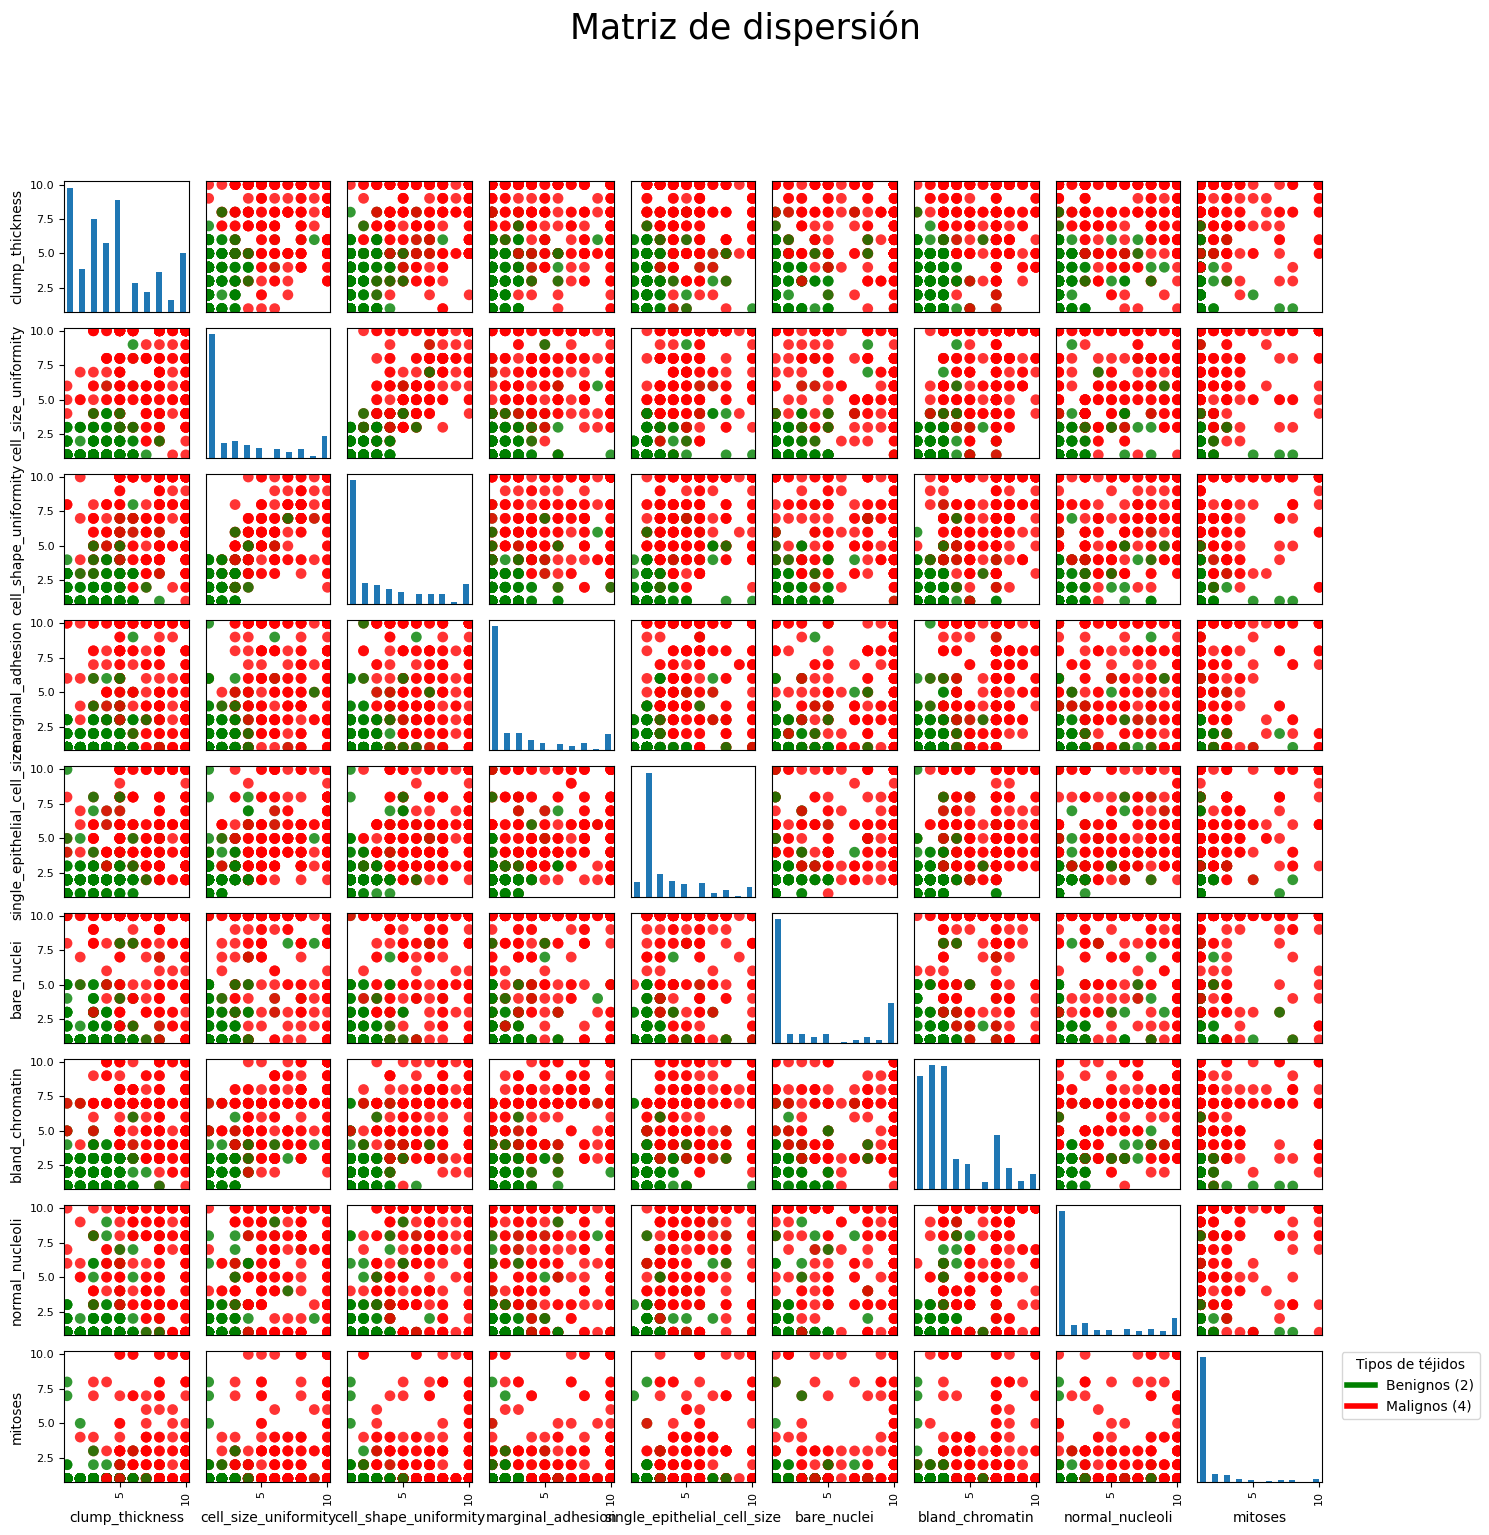

In [28]:
colors = target_column["class"].map({2: 'green', 4: 'red'})
sp = pd.plotting.scatter_matrix(breast_cancer_data_no_target_no_id, c=colors, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

plt.legend(
    handles=[plt.Line2D([0], [0], color='green', lw=4, label='Benignos (2)'),
             plt.Line2D([0], [0], color='red', lw=4, label='Malignos (4)')],
    bbox_to_anchor=(1.1, 1.05),
    title="Tipos de téjidos"
)

plt.suptitle('Matriz de dispersión', fontsize=25, y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.savefig("scatterMatrix.png", bbox_inches="tight")
plt.show()

### Matriz de correlación

Esta matriz nos permite visualizar la correlación que existe entre distintos pares de atributos. Para facilitar su comprensión hemos mostrado dicha matriz tanto con colores como con números.

In [29]:
#
#correlation = breast_cancer_data_no_target_no_id.corr()
#f = plt.figure(figsize=(19, 15))
#plt.matshow(correlation, fignum=f.number)
#plt.xticks(range(breast_cancer_data_no_target_no_id.select_dtypes(['number']).shape[1]), breast_cancer_data_no_target_no_id.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(breast_cancer_data_no_target_no_id.select_dtypes(['number']).shape[1]), breast_cancer_data_no_target_no_id.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#
## Superponer valores de correlación en el gráfico
#for i in range(correlation.shape[0]):
#    for j in range(correlation.shape[1]):
#        plt.text(j, i, f'{correlation.iloc[i, j]:.2f}', ha='center', va='center', color='black')
#
#plt.title('Matriz de correlación', fontsize=25)
#plt.savefig("correlationMatrix.png", bbox_inches="tight")

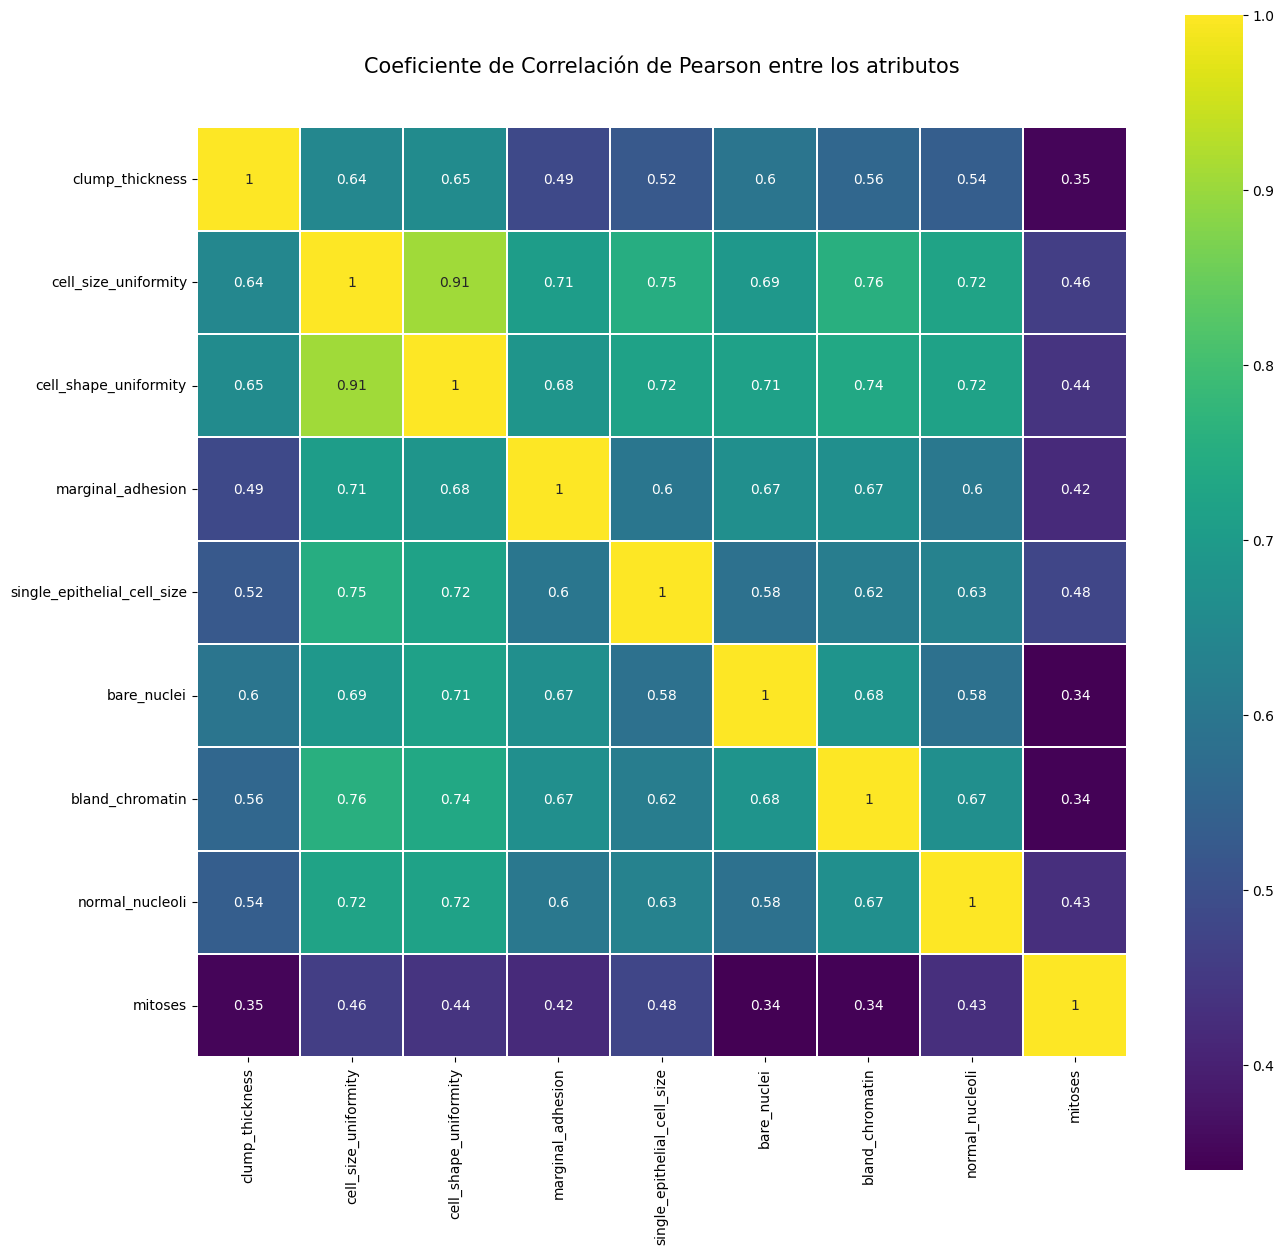

In [30]:
plt.figure(figsize=(15,15))
plt.title('Coeficiente de Correlación de Pearson entre los atributos', y=1.05, size=15)
sns.heatmap(breast_cancer_data_no_target_no_id.corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap='viridis', linecolor='white', annot=True)
plt.savefig("correlationMatrix.png", bbox_inches="tight")

Gracias a estos dos gráfico podemos afirmar que existe una fuerte correlación entre la forma uniforme de las células y su tamaño uniforme, de este modo podemos asegurar que si aumenta la unifirmidad del tamaño también lo hace la uniformidad de su forma, y viceversa.

Observando las matrices de forma más genérica podemos darnos cuenta de que la uniformidad de tamaño y forma esta muy correlacionada con el resto de atributos, ya que para estos dos atributos obtenemos las mayores correlaciones con el resto de propiedades del conjunto de datos.

A continuación, ofrecemos una visualización de una regresión lineal calculada en base a la uniformidad de tamaño y forma de las células.

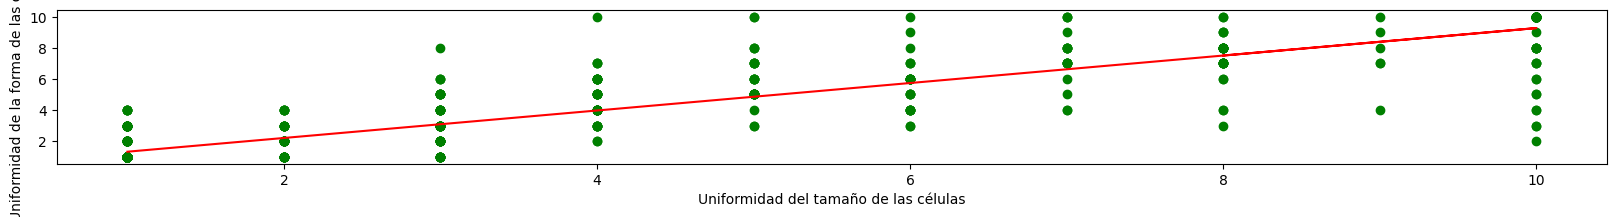

In [31]:
plt.rcParams["figure.figsize"] = (20,2)

cell_size_uniformity = breast_cancer_data_no_target_no_id["cell_size_uniformity"].values.reshape(-1,1)
cell_shape_uniformity = breast_cancer_data_no_target_no_id["cell_shape_uniformity"].values

model_lineal = linear_model.LinearRegression()
model_lineal.fit(cell_size_uniformity, cell_shape_uniformity)

y_model_lineal_pred = model_lineal.predict(cell_size_uniformity)

plt.scatter(cell_size_uniformity, cell_shape_uniformity, color='green')
plt.plot(cell_size_uniformity, y_model_lineal_pred, color='red')
plt.xlabel('Uniformidad del tamaño de las células')
plt.ylabel('Uniformidad de la forma de las células')
plt.show()

# Árboles de decisión

Tras haber realizado un análisis de los datos, el cuál nos permite familiarizarnos con su naturaleza, vamos a contruir un árbol de decisión. Todo ello mediante [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [32]:
model = DecisionTreeClassifier(random_state=10)

print(breast_cancer_data_no_target_no_id.values[:5])
print(target_column.values.ravel()[:5])

[[ 5.  1.  1.  1.  2.  1.  3.  1.  1.]
 [ 5.  4.  4.  5.  7. 10.  3.  2.  1.]
 [ 3.  1.  1.  1.  2.  2.  3.  1.  1.]
 [ 6.  8.  8.  1.  3.  4.  3.  7.  1.]
 [ 4.  1.  1.  3.  2.  1.  3.  1.  1.]]
[2 2 2 2 2]


Obtenemos subconjuntos de datos a partir del conjunto original, para de este modo contar con datos de entrenamineto y datos de prueba. Para ello usamos la función [`train_test_split`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html). En ella definimos 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer_data_no_target_no_id.values, target_column.values.ravel(), test_size=0.3, random_state=645)

Entrenamos los datos mediante el método **fit**, al cual debemos de proporcionarle los datos de entrenamiento y el resultado esperado:

In [34]:
model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

Podemos representar el árbol generado mediante [`export_text`](https://scikit-learn.org/dev/modules/generated/sklearn.tree.export_text.html). Solo debemos proporcionale como argumentos el modelo y las columnas del dataset relevante para el entrenamiento, es decir, descartando "id" y la columna objetivo "class".

In [35]:
model_columns = [i for i in columns if i != "id" and i != "class"]
model_text = export_text(model, feature_names=model_columns)
print(model_text)

|--- cell_size_uniformity <= 2.50
|   |--- normal_nucleoli <= 3.50
|   |   |--- clump_thickness <= 7.50
|   |   |   |--- bare_nuclei <= 4.50
|   |   |   |   |--- class: 2
|   |   |   |--- bare_nuclei >  4.50
|   |   |   |   |--- single_epithelial_cell_size <= 1.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- single_epithelial_cell_size >  1.50
|   |   |   |   |   |--- class: 2
|   |   |--- clump_thickness >  7.50
|   |   |   |--- bare_nuclei <= 2.00
|   |   |   |   |--- class: 2
|   |   |   |--- bare_nuclei >  2.00
|   |   |   |   |--- class: 4
|   |--- normal_nucleoli >  3.50
|   |   |--- clump_thickness <= 3.50
|   |   |   |--- class: 2
|   |   |--- clump_thickness >  3.50
|   |   |   |--- class: 4
|--- cell_size_uniformity >  2.50
|   |--- cell_shape_uniformity <= 2.50
|   |   |--- clump_thickness <= 5.50
|   |   |   |--- bare_nuclei <= 6.50
|   |   |   |   |--- class: 2
|   |   |   |--- bare_nuclei >  6.50
|   |   |   |   |--- class: 4
|   |   |--- clump_thickness >  5.50

Podemos exportar el gráfico generado medinate la función [`export_graphviz`](https://scikit-learn.org/dev/modules/generated/sklearn.tree.export_graphviz.html). Esta función nos proporciona un archivo **.dot**, el cual podemos visualizar mediante [`graphviz`](https://www.graphviz.org/download). A su vez, podemos usar la extensión [`Graphviz Preview`](https://marketplace.visualstudio.com/items?itemName=EFanZh.graphviz-preview) de [`Visual Studio Code`](https://code.visualstudio.com) para previsualizar el archivo. El archivo lo llamaremos gini1.dot, ya que por defecto [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) usa [`Gini`](https://www.maximaformacion.es/blog-dat/que-son-los-arboles-de-decision-y-para-que-sirven/#:~:text=El%20índice%20de%20Gini%20mide,variable%20con%20menor%20Gini%20ponderado) para como criterio para determinar el grado de dispersión del nodo.

In [36]:
export_graphviz(
    model,
    out_file="gini_1.dot",
    feature_names=model_columns,
    rounded=True,
    filled=True)

Tambien podemos visualizar el arbol generado mediante python y matplotlib. Para ello, primero generamos el árbol como un archivo PNG y luego lo visualizamos mediante [`matplotlib`](https://matplotlib.org)

1. Teniendo [`graphviz`](https://www.graphviz.org/download) instalado podemos generar un archivo PNG mediante el siguiente comando:

In [37]:
!dot -Tpng gini_1.dot -o gini_1.png

2. Usando [`matplotlib`](https://matplotlib.org) cargamos la imagen generada anteriormente y la mostramos.

<Figure size 2000x200 with 0 Axes>

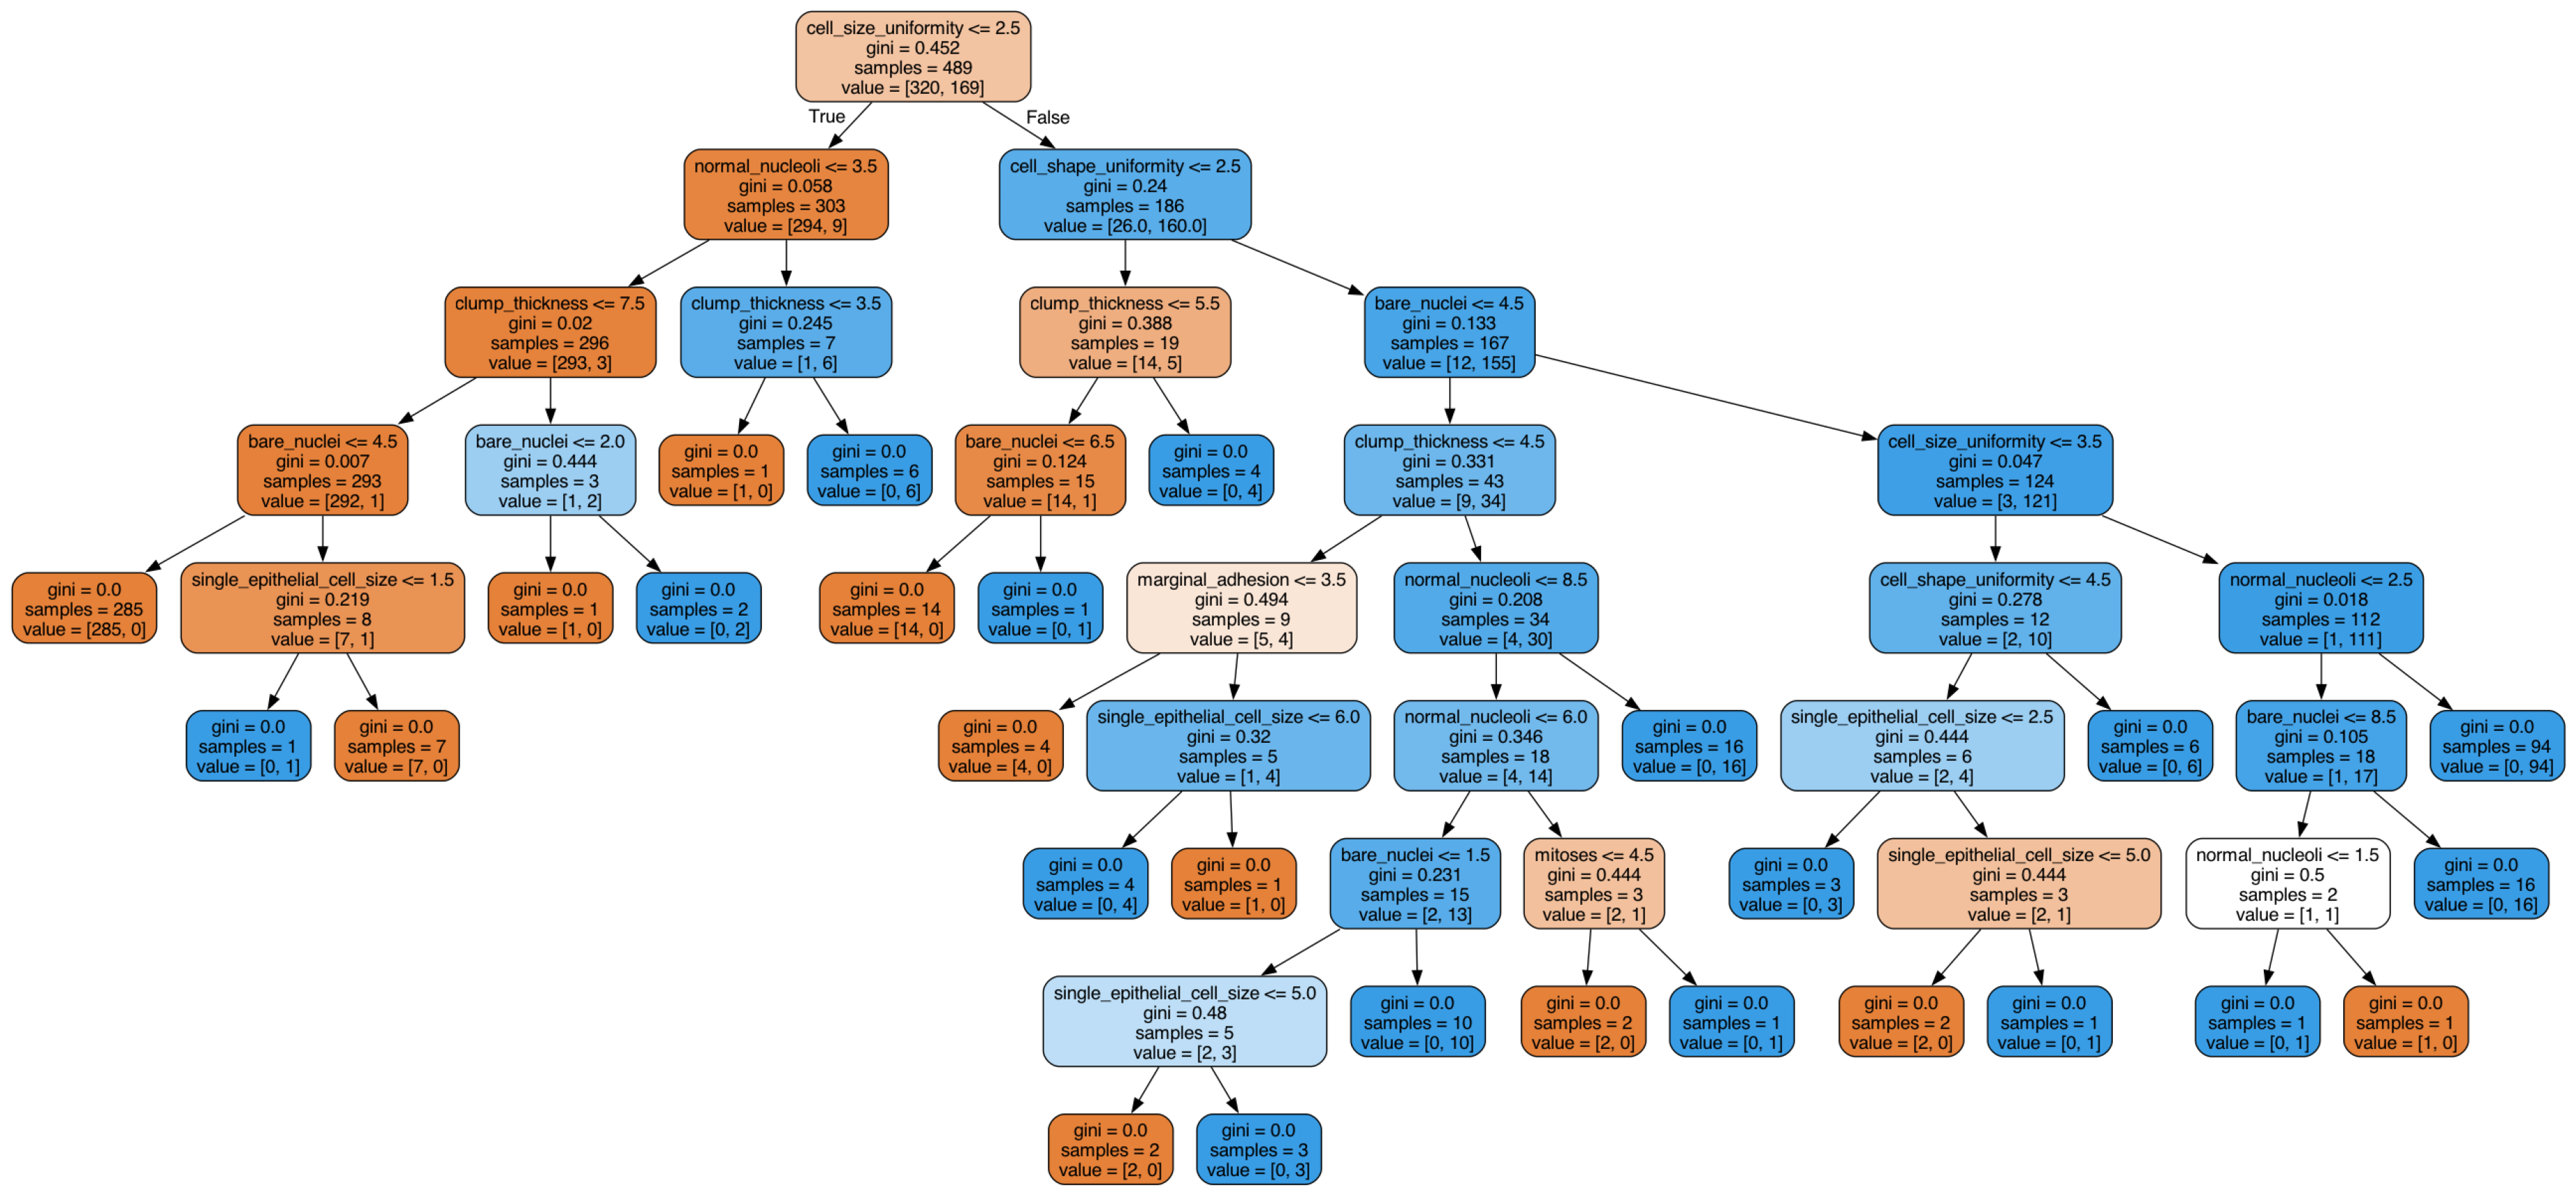

In [38]:
plt.clf()
image = plt.imread("gini_1.png")
height, width, depth = image.shape
dpi = 70
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
plt.axis('off')
plt.imshow(image)
plt.show()

En la representación podemos observar que se ha empleado el coeficiente de Gini para generar el árbol. Dicho coeficiente es calculado mediante la fórmula:

$$G({\cal S}) = 1 - \sum_{j=1}^k {p_j}^2$$

El algoritmo calcula dicho coeficiente para cada nodo y determina que ha alcanzado una hoja cuando este tiene valor de 0. Esto es debido a que el coeficiente de Gini determina la dispersión presente en el nodo, por lo que si es 0 significa que ninguno de los datos restantes presentan variación.

A partir del diagrama generado podemos confirmar que la elección de nodos mediante Gini viene determinada por un criterio maximal, es decir, conforme construimos el árbol buscamos el siguiente nodo, dentro de los restantes que pesente mayor coeficiente. En base a este criterio se ha seleccionado la uniformidad del tamaño de la célula como criterio inicial. 

Ver que existen nodos en un nivel inferior a otro con menor coeficiente de Gini podría desorientarnos, pero esto es debido a que este coeficiente mide el grado de impureza, por lo que aunque un no nodo hijo tenga un coeficiente mayor que el padre, esto puede deberse a que en este punto del proceso los datos están más "depurados", por lo que si se usase este nodo hijo en el lugar del padre, obtendríamos un coeficiente menor que el original.

Existe otro método para visualizar los datos mediante python, sin necesidad de generar ficheros adicionales, mediante [`plot_tree`](https://scikit-learn.org/1.5/modules/generated/sklearn.tree.plot_tree.html).

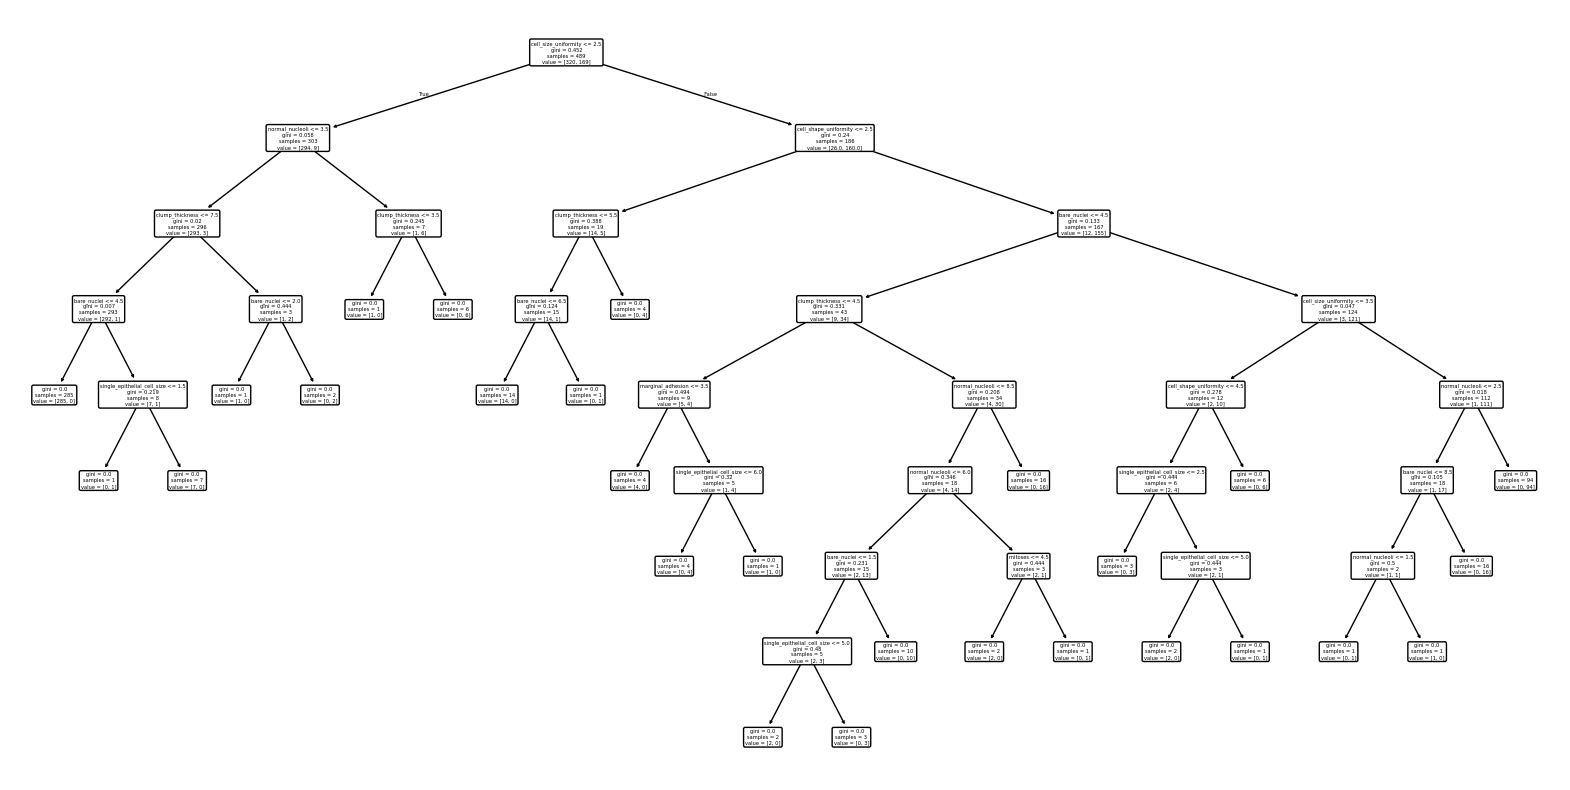

In [39]:
plt.rcParams["figure.figsize"] = (20,10)
plot_tree(model,rounded=True,feature_names=model_columns)
plt.show()

En caso de que queramos calcular la dispermsión mediante otro criterio podemos especificarlo cuando creamos el modelo mediante el parámetro `criterion` del constructor de la clase `DecisionTreeClassifier`. Los valores disponibles son `gini` para usar el índice de Gini y `entropy` para usar la ganancia de información. Un ejemplo de ello sería:

In [40]:
model_entropy = DecisionTreeClassifier(criterion='entropy')
model_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

La visualización de este árbol sería:

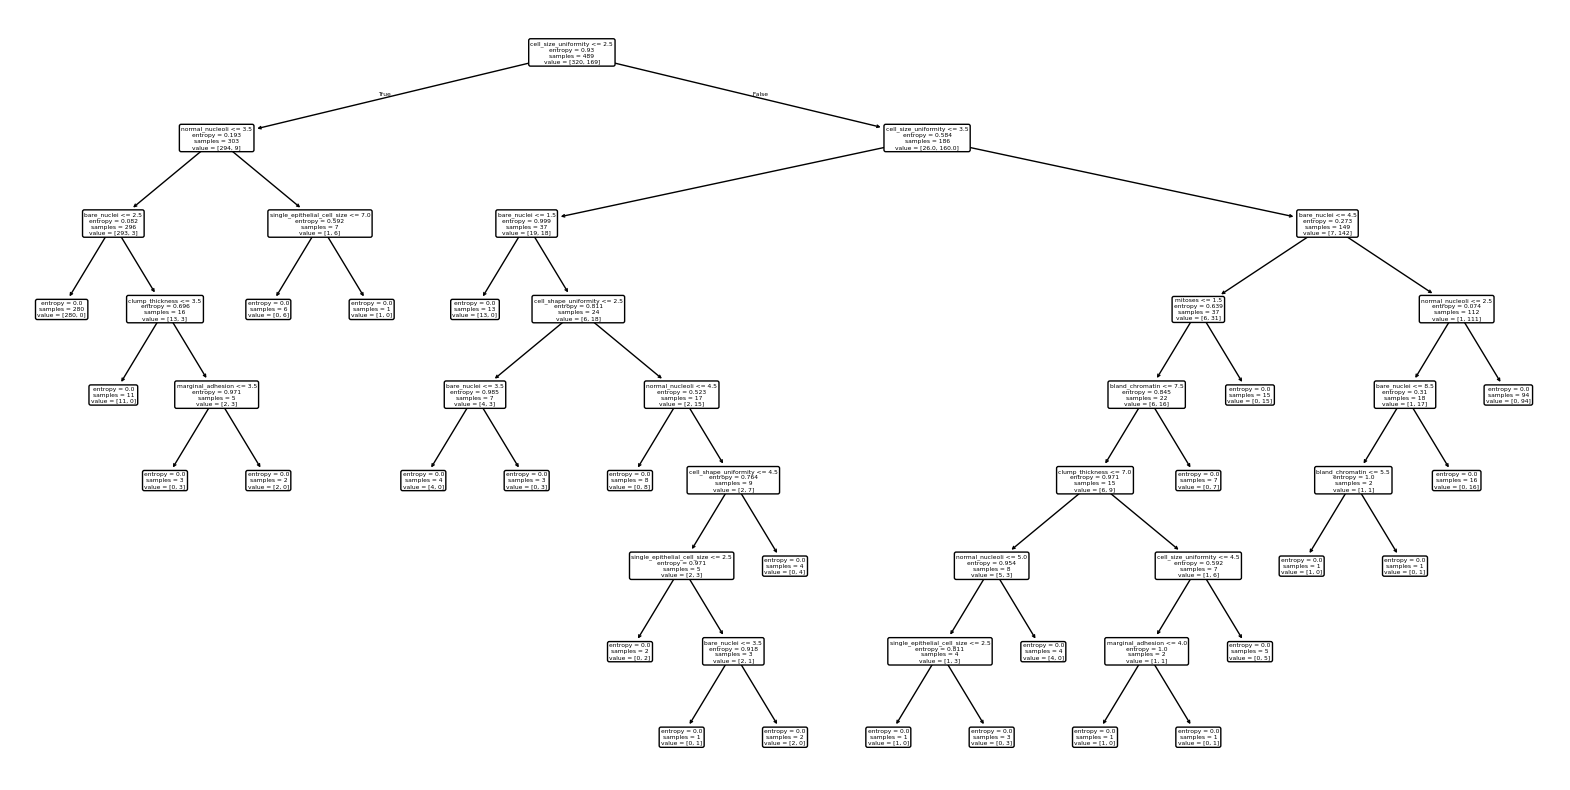

In [41]:
plot_tree(model_entropy,rounded=True,feature_names=model_columns)
plt.show()

Dependiendo del criterio seleccionado, el árbol de decisión generado puede variar.

Mediante la función `representacion_grafica`, la cual se ha facilitado en clase, representaremos la despiersión de las dos variables del dataset que presentan mayor correlación.

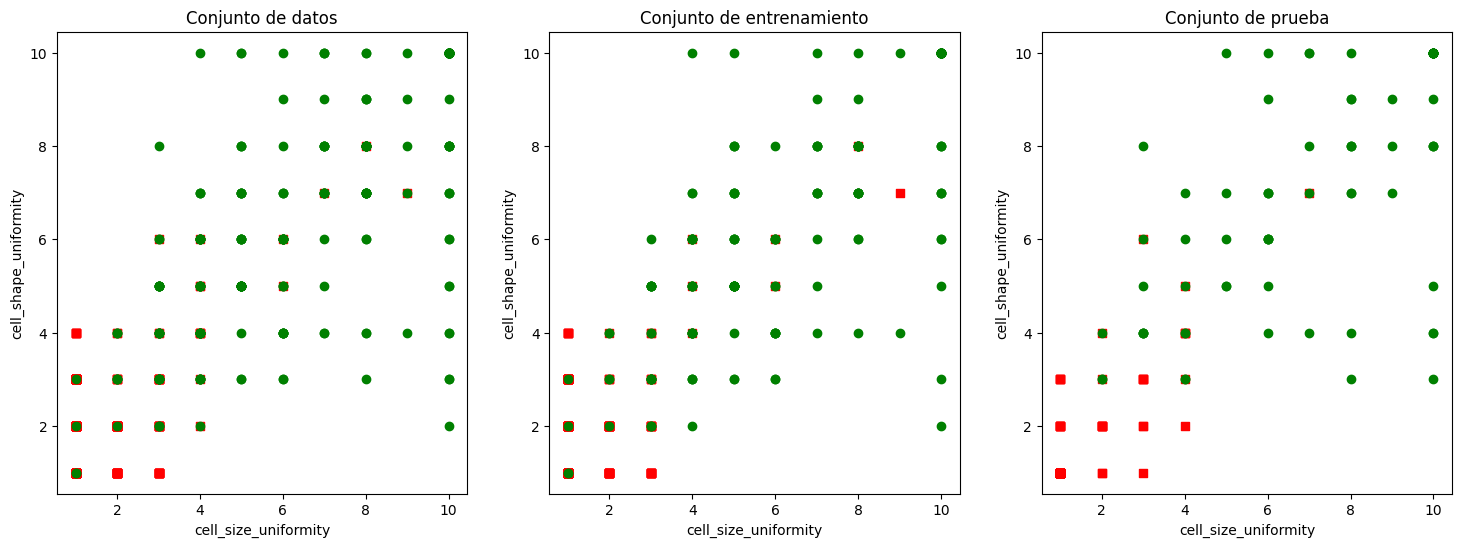

In [42]:
def representacion_grafica(datos,caracteristicas,objetivo,clases,c1,c2):
    objetivo = np.where(objetivo == 2, 0, 1)
    for tipo,marca,color in zip(range(len(clases)),"soD","rgb"):
        plt.scatter(datos[objetivo == tipo,c1],
                    datos[objetivo == tipo,c2],marker=marca,c=color)
    plt.xlabel(caracteristicas[c1])
    plt.ylabel(caracteristicas[c2])

plt.rcParams["figure.figsize"] = [18,6]
plt.clf()
splt = plt.subplot(131)

splt.set_title("Conjunto de datos")
representacion_grafica(breast_cancer_data_no_target_no_id.values, model_columns, target_column.values.ravel(), ["Benigno", "Maligno"],1,2)
splt = plt.subplot(132)

splt.set_title("Conjunto de entrenamiento")

representacion_grafica(X_train, model_columns, y_train, ["Benigno", "Maligno"], 1, 2 )

splt = plt.subplot(133)

splt.set_title("Conjunto de prueba")
representacion_grafica(X_test, model_columns, y_test, ["Benigno", "Maligno"],1,2)
plt.show()

A continuación calcularemos la Medida de rendimiento como la proporción de aciertos sobre el conjunto de test. 

Para ello, calculamos las predicciones para posteriormente comparar los valores obtenidos con los esperados:

In [43]:
y_pred = model.predict(X_test)

La proporcion de aciertos podemos calcularla como:


$$\text{Accuracy} = \frac{\sum_{i=1}^N \mathbb{1}(y_{\text{pred}, i} = y_{\text{test}, i})}{N}$$

Donde: 
- N es el número total de muestras.
- La función tomará el valor de 1 si coincide la prediccón con el valor esperado, 0 en caso contrario.

Podmos programar esta función mediante python de la siguiente manera:

In [44]:
right = sum(x1==x2 for x1,x2 in zip(y_pred, y_test))/len(y_test)
print(f"Se ha obtenido un porcentaje de acierto del {right :.3f}%")

Se ha obtenido un porcentaje de acierto del 0.929%


Para conocer el comportamiento dentro del conjunto de datos, calcularemos el porcentaje de acierto del modelo tanto dentro del conjunto de test como dentro del de entrenamiento, así como del dataset al completo. Para facilitar el cálcula vamos a emplear la función `score` que ya nos proporciona Scikit learn.

In [45]:
print("Rendimiento en el conjunto de entrenamiento: ",model.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",model.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",model.score(breast_cancer_data_no_target_no_id.values,target_column.values.ravel()))

Rendimiento en el conjunto de entrenamiento:  1.0
Rendimiento en el conjunto de prueba:  0.9285714285714286
Rendimiento en el conjunto total:  0.9785407725321889


Podemos observar las matrices de confusión:

In [46]:
confusion_matrix_train = skm.confusion_matrix(y_train, model.predict(X_train))
confusion_matrix_test = skm.confusion_matrix(y_test, model.predict(X_test))

print('Matrices de confusión')
print('\nEntrenamiento:')
print(confusion_matrix_train)
print('\nPruebas:')
print(confusion_matrix_test)

Matrices de confusión

Entrenamiento:
[[320   0]
 [  0 169]]

Pruebas:
[[130   8]
 [  7  65]]


Graficamente la matriz de confusión del conjunto de datos de test sería:

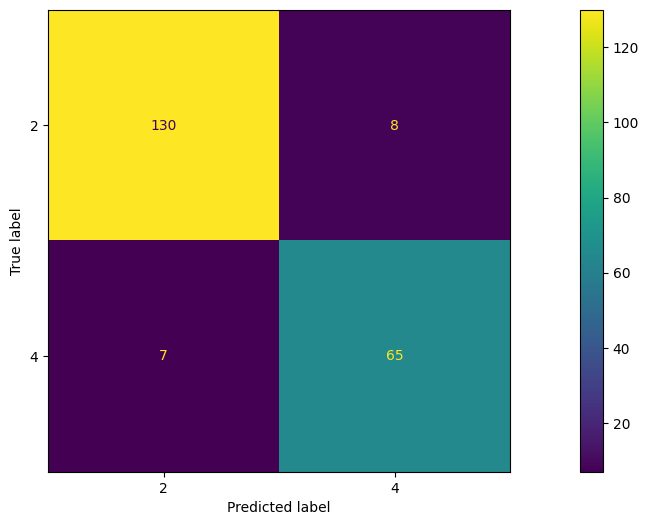

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test,
                              display_labels=model.classes_)
disp.plot()

Podemos calcular la [`Validación cruzada`](https://es.wikipedia.org/wiki/Validación_cruzada) para poder medir el rendimiento del modelo. Este método se basa en dividir el conjunto de entrenamiento en k conjuntos, volviendo a realizar el entrenamiento sobre cada uno de esos conjuntos de forma aislada usando k-1 subconjuntos de entrenamiento, usando el resto para luego poder validar la respuesta. Decimos que es estratificada porque en caso de haber desproporción entre los distintos posibles valores objetivo, el algoritmo tratará de dividir el conjunto de datos en k subconjuntos tratando de mantener en cada uno de ellos esta relación de proporción.

In [48]:
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 955 )
scores = cross_val_score(model, X_train, y_train,
                                 scoring = "accuracy", cv = cross_validation, n_jobs = 1 )

scores

array([0.91836735, 0.95918367, 0.93877551, 0.83673469, 0.91836735,
       0.95918367, 0.91836735, 0.93877551, 0.97959184, 0.91666667])

La variable "`scores`" devuelve el rendimiento de cada entrenamiento obviando el 10% en cada iteración. Lo más intersante sería conocer los valores globales, es por ello que vamos a calcular la media y la desviación tipica.

In [49]:
print( "Rendimiento: Valor medio %0.5f y desviación típica %0.5f)" % (scores.mean(), scores.std()))

Rendimiento: Valor medio 0.92840 y desviación típica 0.03684)


Como vimos anteriormente, con la elección del criterio de dispersión, podemos elegir diferentes tipos de hiprparámetros, la elección de estos condicionará el aprendizaje del modelo, permitiendo obtener un mejor resultado o no. Algunos de los hiperparámetros en los árboles de decisión son el número mínimo de elementos para dividir un nodo o la profundidad máxima del árbol.

A continuación, veremos un ejemplo de ello.

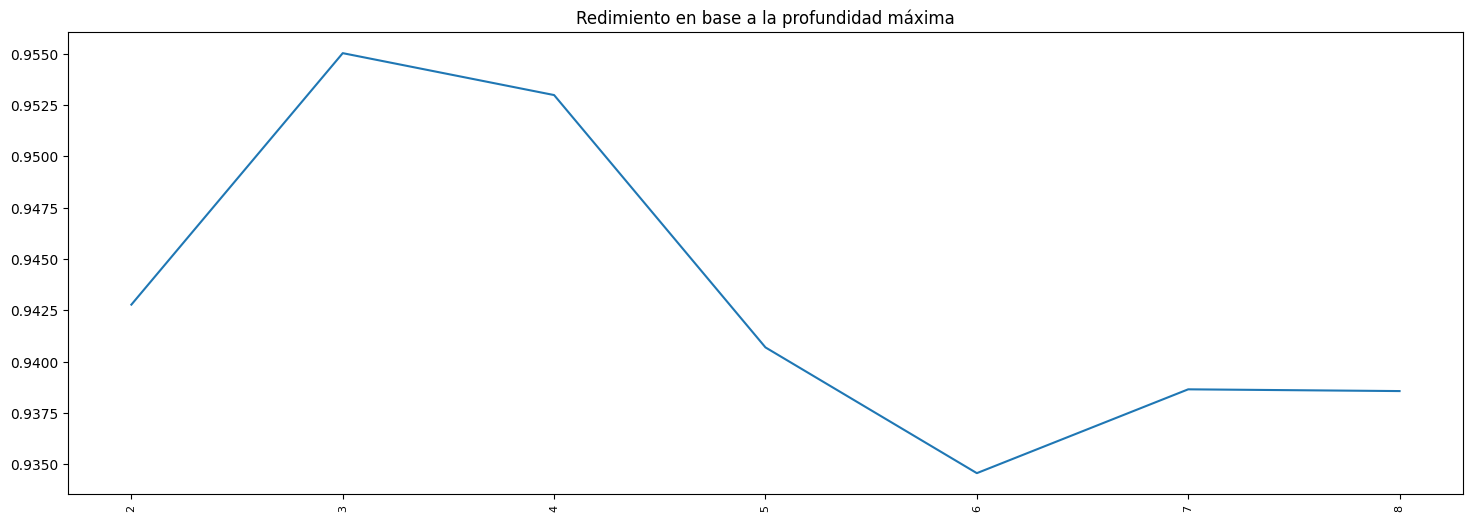

In [752]:

max_detph = len(model_columns)
means = []
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 955 )

for i in range(2, max_detph):
    x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(breast_cancer_data_no_target_no_id.values, target_column.values.ravel(), test_size=0.30, random_state=589)
    tree_aux = DecisionTreeClassifier(max_depth=i)
    tree_aux.fit(x_train_aux, y_train_aux)
    scores = cross_val_score(tree_aux, x_train_aux, y_train_aux, scoring='accuracy', cv=cross_validation, n_jobs=1)
    mean_score = scores.mean()
    means.append(mean_score)
  
plt.title("Redimiento en base a la profundidad máxima")  
plt.xticks(range(len(means)), range(2, max_detph), rotation=90, fontsize=8)
plt.plot(means)
plt.show()

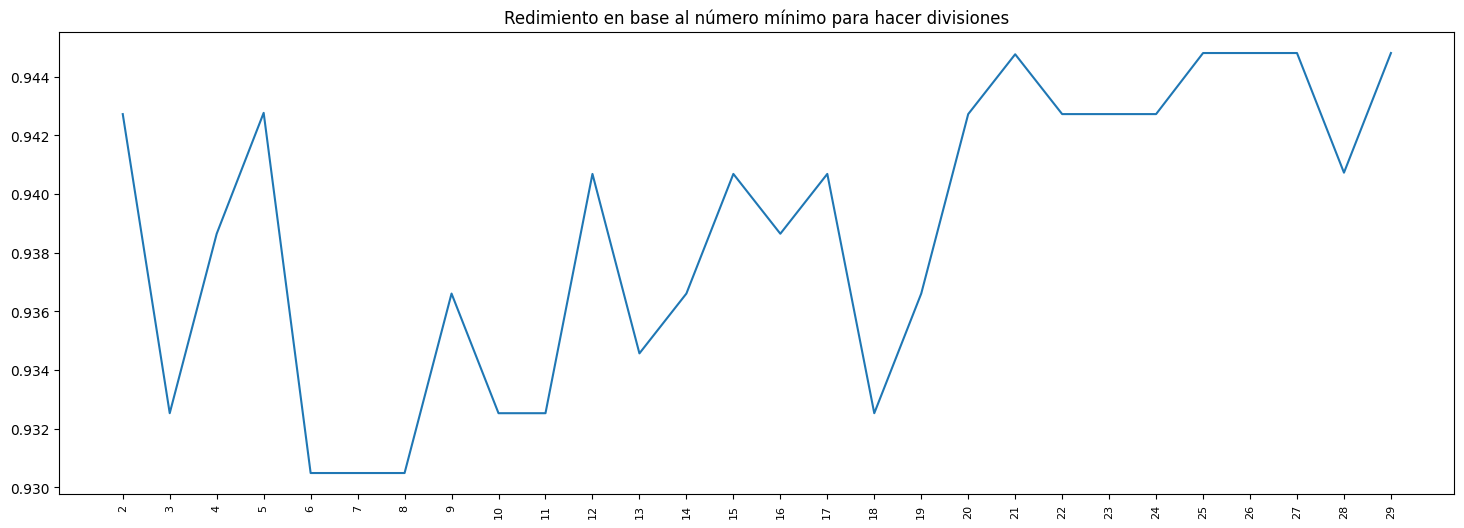

In [739]:
min_samples_split = 30
means = []
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 955 )

for i in range(2, min_samples_split):
    x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(breast_cancer_data_no_target_no_id.values, target_column.values.ravel(), test_size=0.30, random_state=589)
    tree_aux = DecisionTreeClassifier(min_samples_split=i)
    tree_aux.fit(x_train_aux, y_train_aux)
    scores = cross_val_score(tree_aux, x_train_aux, y_train_aux, scoring='accuracy', cv=cross_validation)
    mean_score = scores.mean()
    means.append(mean_score)
  
plt.title("Redimiento en base al número mínimo para hacer divisiones")  
plt.xticks(range(len(means)), range(2, min_samples_split), rotation=90, fontsize=8) 
plt.plot(means)
plt.show()

De este modo podemos observar como dependiendo de la elección de hiperparámetros realizada obtendremos un resultado más cercano de la realidad u otro más alejado.
En el caso estudiado vemos como con una profundida máxima de 3 ya obtenemos resultados muy buenos, a la par que, como vemos en el segundo ejemplo, con un mínimo de 5 ejemplos para realizar un división tambien concluimos con muy buenos resultados.

Pero debemos tener en cuenta que en ambos casos hemos estudiado la elección de un hiperparámetro sin personalizar el resto, y al aplicar un hiperparámetro podría afectar a los resultados obtenidos empleando el otro.

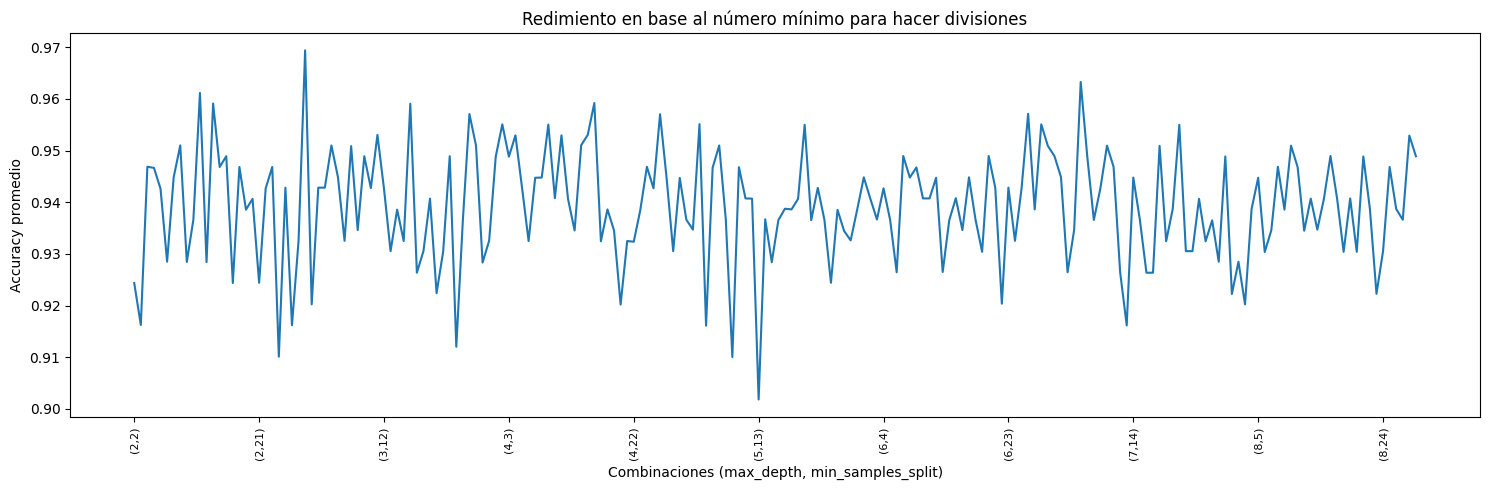

In [655]:
max_detph = len(model_columns)
min_samples_split = 30
means = []
combinations = [] 

cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 955 )

for i in range(2, max_detph):
    x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(breast_cancer_data_no_target_no_id.values, target_column.values.ravel(), test_size=0.70)
    for j in range(2, min_samples_split):
        x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(breast_cancer_data_no_target_no_id.values, target_column.values.ravel(), test_size=0.30)
        tree_aux = DecisionTreeClassifier(max_depth=i, min_samples_split=j)
        tree_aux.fit(x_train_aux, y_train_aux)
        scores = cross_val_score(tree_aux, x_train_aux, y_train_aux, scoring='accuracy', cv=cross_validation) 
        mean_score = scores.mean()
        means.append(mean_score)
        combinations.append(f"({i},{j})")
        
plt.figure(figsize=(15, 5))
plt.title("Redimiento en base al número mínimo para hacer divisiones")  
plt.plot(means)
step = max(1, len(combinations) // 10)
plt.xticks(
    range(0, len(combinations), step),
    [combinations[i] for i in range(0, len(combinations), step)],
    rotation=90, fontsize=8
)

plt.xlabel("Combinaciones (max_depth, min_samples_split)")
plt.ylabel("Accuracy promedio")
plt.tight_layout()
plt.show()

Afortunadamente, `Scikit learn` nos provee de funciones como [`GridSearchCV`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) o [`HalvingGridSearchCV`](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) que nos permiten determinar las mejores combinaciones de hiperparámetros.

In [656]:
t_start = time.time()
parameters = {
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': [None] + list(range(1,len(model_columns))),
    'max_features':['sqrt', 'log2'],
    'max_leaf_nodes':[None, 10, 15, 25, 50],
    'min_impurity_decrease':[0.0, 0.001, 0.01],
    'min_samples_leaf':[3, 5, 8, 10, 12, 14, 20],
    'min_samples_split':[8, 10]
}

clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, cv=10, scoring='accuracy')

clf.fit(breast_cancer_data_no_target_no_id.values, target_column.values.ravel())

print('Se ha tardado {:.2f}s'.format(time.time() - t_start))
print('Mejores hiperparámetros encontrados:', clf.best_params_)

Se ha tardado 78.72s
Mejores hiperparámetros encontrados: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 8}


/Users/sergiosantiago/developments/master/cuestionario_2/venv/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast


Contruimos un nuevo árbol con los valores recomendados, solamente necesitamos especificar aquellos que no se corresponden con los valoeres por defecto.

In [50]:
best_tree = DecisionTreeClassifier(max_depth=3, max_features="sqrt", max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=8)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features='sqrt', max_leaf_nodes=10,
                       min_samples_leaf=3, min_samples_split=8)

Realizamos un análisis del rendimiento del árbol obtenido.

In [51]:
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 955 )
scores = cross_val_score(best_tree, X_train, y_train, scoring='accuracy', cv=cross_validation) 
print(f"La media del score es: {scores.mean()} y su desviación es {scores.std()}")

print("Rendimiento en el conjunto de entrenamiento: ",best_tree.score(X_train,y_train))
print("Rendimiento en el conjunto de prueba: ",best_tree.score(X_test,y_test))
print("Rendimiento en el conjunto total: ",best_tree.score(breast_cancer_data_no_target_no_id.values,target_column.values.ravel()))

La media del score es: 0.9509353741496598 y su desviación es 0.02078051057127669
Rendimiento en el conjunto de entrenamiento:  0.9611451942740287
Rendimiento en el conjunto de prueba:  0.9571428571428572
Rendimiento en el conjunto total:  0.9599427753934192


Obervamos como ha reducido su rendimiento dentro del conjunto de entrenamiento, a la vez que lo incrementa en el de pruebas.

Mostramos el árbol resultante:

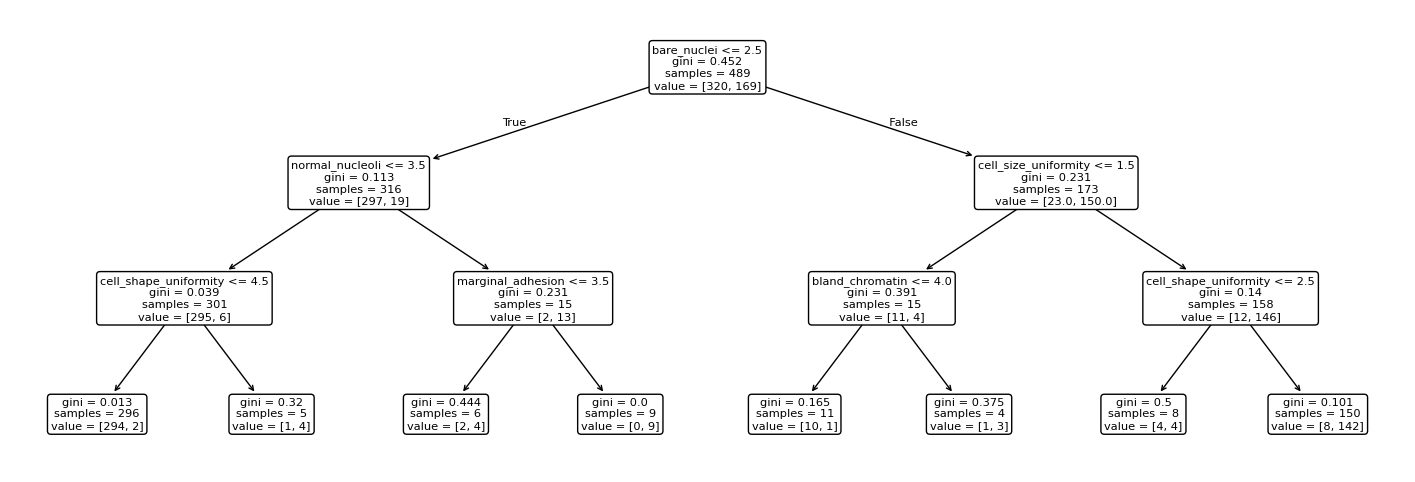

In [52]:
plot_tree(best_tree,rounded=True,feature_names=model_columns)
plt.show()

# Visualización

In [53]:
import dtreeviz

In [54]:
class_names=["benign", "malignant"]

Durante las clases nos han recomendado emplear [`dtreeviz`](https://github.com/parrt/dtreeviz?tab=readme-ov-file) para llevar a cabo la visualización del árbol genereado. Con el objetivo de comprender su funcionamiento, vamos a hacer uso de este paquete para visualizar el resultado del entrenamiento, ya que contamos con información adicional proporcionada en clase.

In [55]:
viz_model = dtreeviz.model(best_tree,
                           X_train=breast_cancer_data_no_target_no_id.values, y_train=target_column.values.ravel(),
                           feature_names=list(model_columns),
                           target_name='class',
                           class_names=class_names)

Si tratamos de visualizar el árbol tal y como lo hemos entranado hasta ahora, obtendremos un error. Podemos comprobarlo si ejecutamos el código comentado más abajo. Este error es debido a que el modelo esta entrenado para responder con 2 y 4 en base a los datos de entrada mientras que `dtreeviz` necesita que los valores de salida sean 0 o 1. Es por ello que nos vemos en la necesidad de reentrenar el arbol, en esta ocasión modificando los valores de salida de entrenamiento para que en lugar de 2 y 4 sean 0 y 1.

In [56]:
#viz_model.view()  # Discomment to see the error

Mapeamos la columna objetivo y reentrenamos el árbool.

In [57]:
target_column_mapped = target_column["class"].map({2:0, 4:1})
x_train, x_test, y_train, y_test = train_test_split(breast_cancer_data_no_target_no_id.values, target_column_mapped.values, test_size=0.30, random_state=645)
final_tree = DecisionTreeClassifier(max_depth=3, max_features="sqrt", max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=8)
final_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, max_features='sqrt', max_leaf_nodes=10,
                       min_samples_leaf=3, min_samples_split=8)

Realizamos nuevamente el análisi del rendimiento para asegurarnos de que al modificar los datos de entrenamiento no hemos cometido ningún error que perjudique a la elaboración del árbol.

In [58]:
cross_validation = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 955 )
scores = cross_val_score(final_tree, x_train, y_train, scoring='accuracy', cv=cross_validation) 
print(f"La media del score es: {scores.mean()} y su desviación es {scores.std()}")

print("Rendimiento en el conjunto de entrenamiento: ",final_tree.score(x_train,y_train))
print("Rendimiento en el conjunto de prueba: ",final_tree.score(x_test,y_test))
print("Rendimiento en el conjunto total: ",final_tree.score(breast_cancer_data_no_target_no_id.values,target_column_mapped.values))

La media del score es: 0.9387329931972788 y su desviación es 0.02032335161976656
Rendimiento en el conjunto de entrenamiento:  0.9631901840490797
Rendimiento en el conjunto de prueba:  0.9285714285714286
Rendimiento en el conjunto total:  0.9527896995708155


Tras realizar esta serie de ajustes, volvemos a crear el modelo de visualización.

In [59]:
viz_model = dtreeviz.model(final_tree,
                           X_train=breast_cancer_data_no_target_no_id.values, y_train=target_column_mapped.values,
                           feature_names=list(model_columns),
                           target_name='class',
                           class_names=class_names)

Podemos emplear el método `.view()` para obtener una visión interactiva del árbol de decisión generando una imagen que ilustra los disitntos criterios en los que se basa el árbol para llegar a una clasificación.

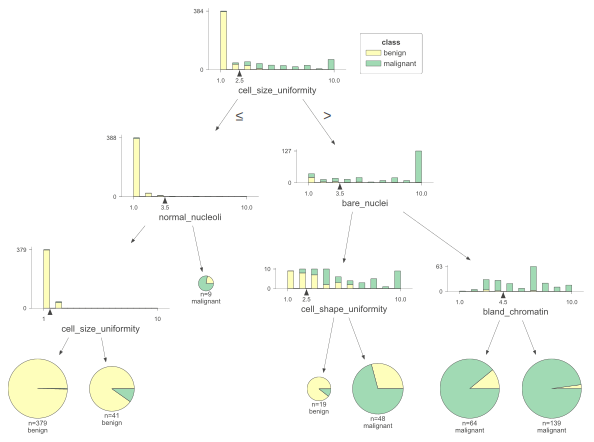

In [60]:
viz_model.view() 

Mediante el método `.ctree_feature_space()` podemos visualizar la separación que realiza el algoritmo entre pares de variables seleccionados en el momento de tomar una decisión.

Por ejempplo, para comparar la uniformidad de tamaño contra la uniformidad de la forma de las células.

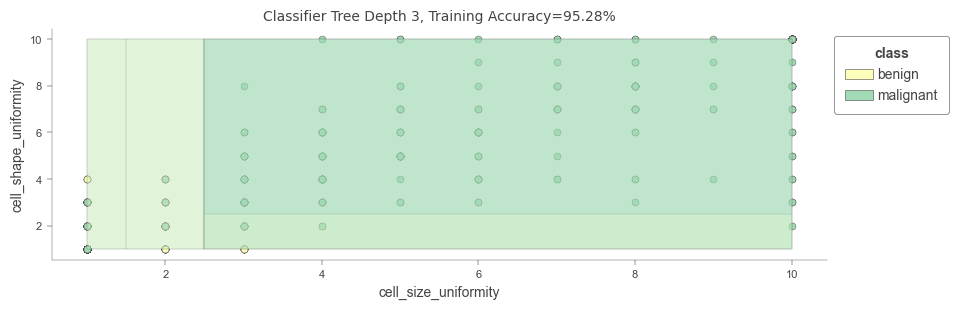

In [61]:
viz_model.ctree_feature_space(show={'splits','title', 'legend'}, features=model_columns[1:3],figsize=(10,3))


Por otro lado en el caso de la uniformidad de forma frente al número de núcleos desnudos obtenemos:

['clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses']


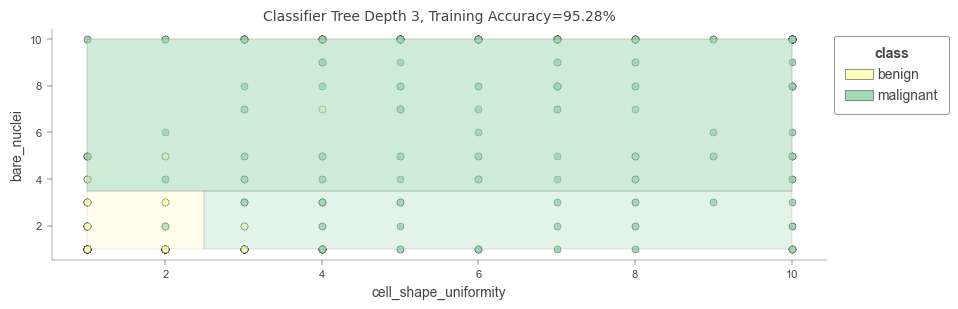

In [62]:
print(model_columns)
viz_model.ctree_feature_space(show={'splits','title', 'legend'}, features=[model_columns[2], model_columns[5]],figsize=(10,3))


En la imagen podemos observar como muestra los puntos por colores, indicando su valor real a la par que los situa en franjas, las cuales representan la predicción realizada para esos puntos.

Otro ejemplo sería la uniformidad de forma frente a la homogeniedad de la cromatina.

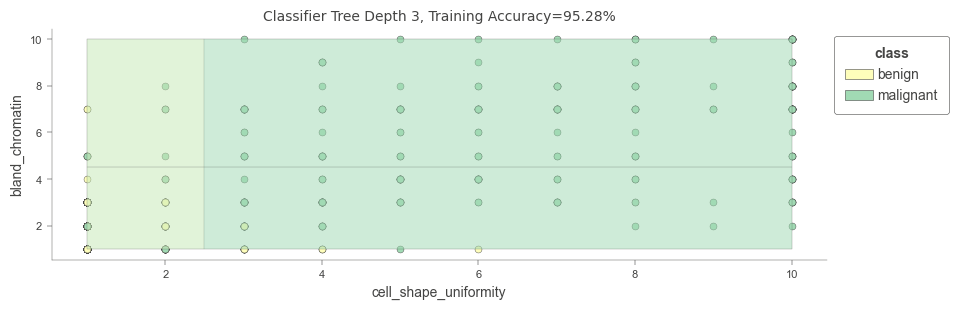

In [63]:
viz_model.ctree_feature_space(show={'splits','title', 'legend'}, features=[model_columns[2], model_columns[6]],figsize=(10,3))


# Complementando el análisis

## k-means

El algoritmo [`k-means`](https://en.wikipedia.org/wiki/K-means_clustering), el cual tiene una implementación realizada en [](scikit-learn)(https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html), permite dentro de un conjunto de datos identificar ciertos grupos, denominados `clusters`, o clasificanes. 

Usar este algoritmo dentro del conjunto de datos de entrenamiento podría ser realmente interesante, ya que nos permitiría observar si proporcionándole el número de posibles grupos al algoritmo es capaz de encontrar los criterios pertinentes para separar los datos llegando a una división parecida a la realizada hasta ahora entre `benigno`y `maligno`. Si k-means es capaz de hacer un separación similar significa que existe una relación fuerte entre la variable objetivo y las columnas del dataset. 

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix


In [65]:
x_train, x_test, y_train, y_test = train_test_split(breast_cancer_data_no_target_no_id.values, target_column_mapped.values, test_size=0.30, random_state=645)


In [66]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
kmeans.fit(x_train)

KMeans(n_clusters=2, random_state=0)

In [67]:
training_prediction = kmeans.predict(x_train)
test_prediction = kmeans.predict(x_test)

A continuación, mostraremos las matrices de confusión del modelo entrenado. Mediante esta matriz podremos comprobar cunnto falsos positivos o negativos arroja.

In [68]:
confusion_matrix_train = skm.confusion_matrix(y_train, training_prediction)
confusion_matrix_test = skm.confusion_matrix(y_test, test_prediction)

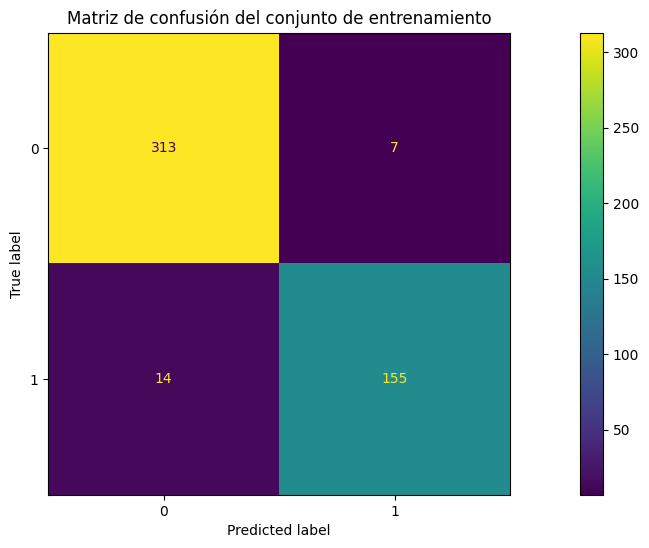

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title("Matriz de confusión del conjunto de entrenamiento")
plt.savefig("kmeans_training.png")
plt.show()

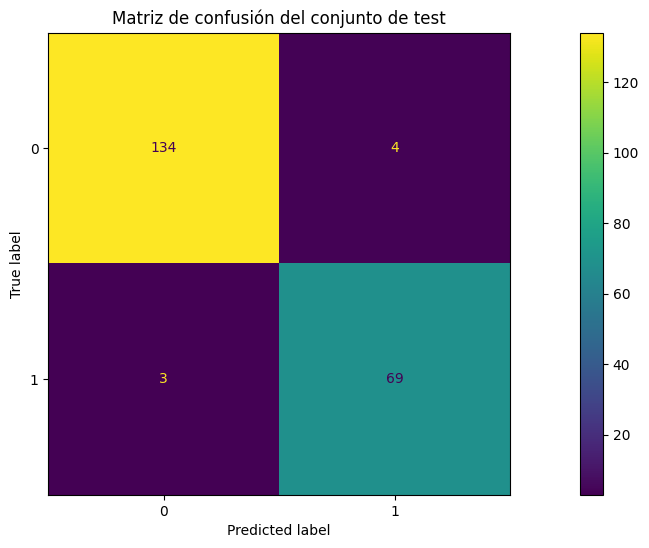

In [70]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test)
disp.plot()
plt.title("Matriz de confusión del conjunto de test")
plt.savefig("kmeans_test.png")
plt.show()

Como podemos observar, la matriz de confusión es realmenete buena, pues en el caso del conjunto de datos de `entrenamiento` solo se ha equivocado en 21 casos mientras que en la de `test`, lo ha hecho en 7 casos.

Gracias a este breve estudio podemos corroborar que efectivamente, existe una fuerte correlación entre los datos recogidos en el dataset y los valores de la variable objetivo.

## SHAP

Los valores Shap permiten, en el contexto de los algoritmos de aprendizaje automático, entender las razones por las que el modelo toma una decisión u otra. Nos proporcionan un medio para entender el funcionamiento de su razonamiento, esto es muy útil para comprobar que se esta fundamentando en características con sentido, y además, en diversos casos puede ofrecernos algunos descubrimientos. Por ejmplo, si el algoritmo está dedicado a la predicción de células cancerosas, podría proporcionarnos una relación que haya descubierto el modelo y para nosotros pasase inadvertida hasta ese momento.

In [157]:
explainer = shap.TreeExplainer(final_tree)

shap_values = explainer.shap_values(breast_cancer_data_no_target_no_id)
print("Dimensiones de shap_values:", shap_values.shape)
print("Dimensiones de los datos:", breast_cancer_data_no_target_no_id.shape)

Dimensiones de shap_values: (699, 9, 2)
Dimensiones de los datos: (699, 9)


Podemos observar que los valores shap son tridimensionales, esto es porque continen referencias a los valores de entrada, los de salida y su importancia para cada posible predicción, en este caso 2 (benigno o maligno).

En el siguiente paso vamos a mostrar un gráfico de violín de los valores Shap. Para el cálculo de los valores hemos empleado el árbol de decisión construido con los hiperparámetros óptimos, `final_tree`. El gráfico representa varias métricas:

- El grosor de cada muestra indica la cantidad de instancias afectadas por esa característica.
- Horientación en X: si se encuentra en el lado derecho implica que favorece devolver `True`.
- Color: En caso de ser azul implica que tiene un peso bajo en la decisión final, por el contrario, si es de color morado, implica que es decisivo para la respuesta.

Dimensiones de shap_values: (699, 9, 2)
Dimensiones de los datos: (699, 9)


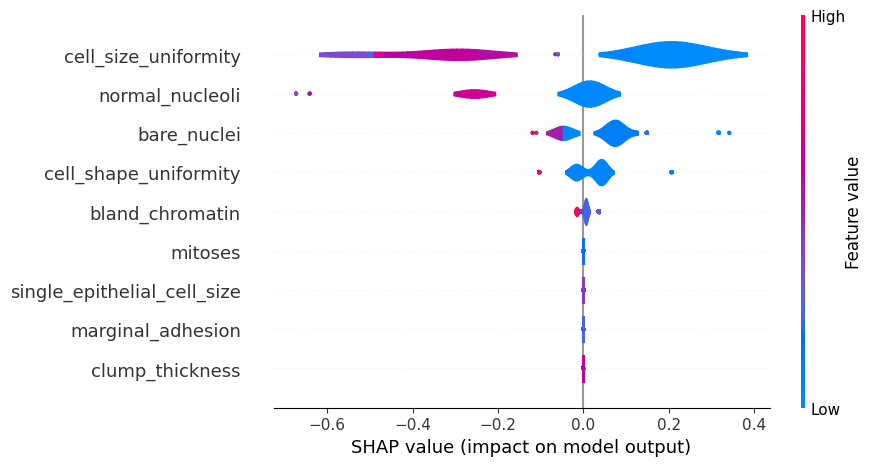

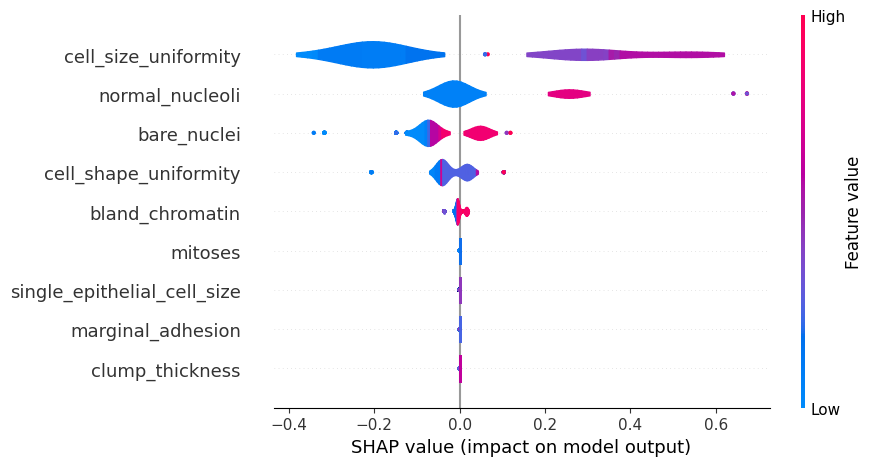

In [171]:
explainer = shap.Explainer(final_tree)
shap_values = explainer(breast_cancer_data_no_target_no_id)
print("Dimensiones de shap_values:", shap_values.shape)
print("Dimensiones de los datos:", breast_cancer_data_no_target_no_id.shape)
shap_values_class_benign = shap_values[..., 0]
shap.plots.violin(shap_values_class_benign) # Benign
shap_values_class_malignant = shap_values[..., 1]
shap.plots.violin(shap_values_class_malignant) # Malignant

Hemos representado 2 gráficos de violin, uno para la posibilidad de benigno y otro para la de maligno, como la predicción es binaria, estos gráficos son simétricos.

En un primer análisis podemos corroborar que la uniformidad en cuanto a tamaño tiene mucha importancia y peso para decidir que la célula es maligna, sin embargo, aunque en caso de ser benigna afecta a muchas instacias, su presencia no tiene tanta importancia en la predicción. También podemos observar como el hecho de no tener nucleolos normales resulta crucial para determinar que la célula es maligna, aunque son pocas las instancias que son afectadas por esta característica.

### Entendiendo una predicción concreta

La librería Sharp tiene una funcionalidad realmente interesante, y es que nos permite profundizar en las razones por las cuáles ha tomado una decisión concreta para una decisión. Es decir, además de poder ver un gráfico global de todo el árbol, podemos visualizar y así entender rapidamente la razón de una decisión en un caso particular. Para esto podemos usar [`Waterfall plot`](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html), se trata de un gráfico que reprsenta para una predicción concreta los pesos de cada propiedad. Al igual que ocurría con el gráfico anterior, este también es simétrico.

Por ejemplo, en el caso de la primera predicción:

La primera predicción es Benigno


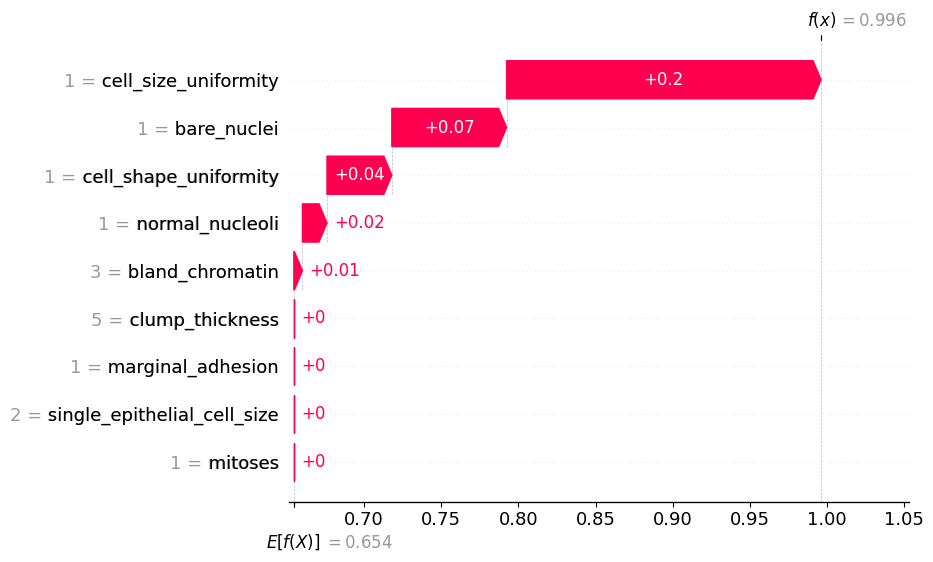

In [178]:
print(f"La primera predicción es { 'Benigno' if target_column_mapped[0] == 0 else 'Maligno' }")
shap.plots.waterfall(shap_values_class_benign[0])

Medinate este gráfico podemos ver como para la primera predicción el atributo màs determinante ha sido la uniformdad de tamaño de la célula, seguido de la cantidad de núcleos desnudos y de la uniformidad de la forma de la célula.

# Conclusiones finales

Tras realizar este análisis no solo disponemos de un modelo capaz de predecir si un cáncer de mama es benigno o no, sino que además hemos podido aprender que características son cruciales en su determinación. 

Como ya pudimos ver en la matriz de dispersión, los valores de salida están claramente separados, es decir, desde el comienzo del análisis podíamos estar practicamente seguros de que podríamos hacer predicciones de calidad, ya que no parecía que el conjunto de datos contuviera demasiado ruido. No obstante, es muy importante realizar los pasos posteriores, ya que así hemos podido conocer el funcionamiento de la clasificación realizada por el algorimo, algo que no solo nos permite aprender, sino que también permite adaptar futuros modelos a necesidades inesperadas. Por ejmplo, un investigador de esta materia podría necesitar eliminar un propiedad del conjunto de datos para no tenerla en cuenta debido a diversos factores, como por ejemplo, que para tener ese dato haya que esperar demasiado. De este modo, se pueden eliminar propiedades que tengan un valor algo más bajo y un coste (económico, humano o temporal) elevado y volver a reentrenar el árbol, tratando de modificar lo mínimo posible el rendimiento del modelo.